#KRW Group Project: Building Narratives from Knowledge Graphs
##Group number: P5-2
###Group members: Fina Polat, Hein Kolk, Jelle Wassenaar, Siddharth Chaubal

This is the second notebook of a series of 3.

Research goal: We are a newspaper agency and want to develop a system to create articles semi-automatically. The goal is to create a newspaper story using information from existing KGs, and to help readers better understanding the content/setting of the story (e.g. visualise a timeline to understand big events and actors in a political or historical event, summarising a movie or the life of someone, etc.).

We are going to generate a gossip story using T5 language model (LM). In order to do that we are going to:
* pre-process WebNLG Dataset - Part 1
* fine-tune T5 language model with WebNLG Dataset. - Part 2
* automatically generate stories (template + automatically generated text) - Part 3

The WebNLG data (Gardent el al., 2017) was created to promote the development (i) of RDF verbalisers and (ii) of microplanners able to handle a wide range of linguistic constructions.

T5 Language Model : Colin Raffel et al. “Exploring the limits of transfer learning with a unified
text-to-text transformer”. In: arXiv preprint arXiv:1910.10683 (2019).

The code in this notebook is adapted from https://github.com/MathewAlexander/T5_nlg

In [ ]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 33.2 MB/s 
     |████████████████████████████████| 895 kB 42.4 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 6.6 MB 35.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [ ]:
### import the required libraries ###

import pandas as pd
import os

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'KRW_P5-2')
drive.mount(MOUNTPOINT)

Mounted at /content/gdrive


In [ ]:
print(DATADIR)

/content/gdrive/My Drive/KRW_P5-2


In [ ]:
#Lets check the file:
train_df=pd.read_csv('/content/gdrive/My Drive/KRW_P5-2/webNLG2020_train.csv', index_col=[0])
#Let's inspect the dataset:
train_df.head

<bound method NDFrame.head of        prefix                                         input_text  \
0      webNLG  (15788)_1993_SB | discoverer | Donal_O'Ceallai...   
1      webNLG  (15788)_1993_SB | discoverer | Donal_O'Ceallai...   
2      webNLG  (15788)_1993_SB | discoverer | Donal_O'Ceallai...   
3      webNLG  (15788)_1993_SB | discoverer | Donal_O'Ceallai...   
4      webNLG  (15788)_1993_SB | discoverer | Donal_O'Ceallai...   
...       ...                                                ...   
35196  webNLG  United_States | leaderTitle | President_of_the...   
35197  webNLG  United_States | leaderTitle | President_of_the...   
35198  webNLG  United_States | leaderTitle | President_of_the...   
35199  webNLG  United_States | leaderTitle | President_of_the...   
35200  webNLG  United_States | leaderTitle | President_of_the...   

                                             target_text  
0      Donal O'Ceallaigh discovered (15788) 1993 SB w...  
1      The celestial body known as 

In [ ]:
#preparation for the training
train_df=train_df.iloc[  :35000,:]
train_df=train_df.sample(frac = 1)
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=2
num_of_batches=int(num_of_batches)

In [ ]:
#set the GPU if available:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
#Loading the pretrained model and tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
# initializing the Adafactor optimizer with parameter values suggested for t5
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [ ]:
num_of_epochs=1

In [ ]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.4998618468659265


In [ ]:
#Serializing the trained model
torch.save(model.state_dict(),'/content/gdrive/My Drive/KRW_P5-2/pytoch_model.bin')

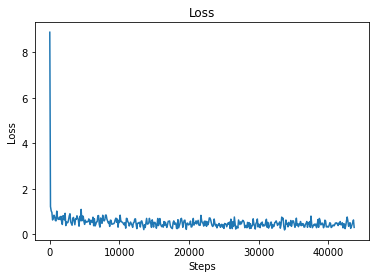

In [ ]:
# Plotting the loss over time
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

The model is finetuned and saved. We don't have to finetune it each time. We can load it from the saved file with config.json

In [ ]:
#Downloading the config file
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json


--2022-03-22 15:08:17--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.139.168
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.139.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json.2’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2022-03-22 15:08:17 (45.7 MB/s) - ‘t5-base-config.json.2’ saved [1199/1199]



In [ ]:
from google.colab import files
files.download('t5-base-config.json') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We got all we need to generate text. All we need to do is to upload the finetuned model from saved directory.

We are going to generate our stories in the Part 3. 